In [1]:
import pickle
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from features.pkl import PickleFeatureWriter
from datasets.hdf5_dataset import HDF5Dataset
import os
from torch.utils.data import DataLoader
from pathlib import Path
from torch.optim import Adam
import torch
from frame_sampling import RandomSampler
from scripts.train_mtrn import train_test_loader
from systems import EpicActionRecogintionShapleyClassifier
from livelossplot import PlotLosses
import numpy as np
from torchvideo.samplers import frame_idx_to_list

# from models.esvs import V_MTRN, N_MTRN

In [2]:
train_labels = Path('/mnt/storage/home/jb18789/scratch/datasets/epic-100/features/67217_train_features.pkl')
test_labels = Path('/mnt/storage/home/jb18789/scratch/datasets/epic-100/features/9668_val_features.pkl')

train = Path('/mnt/storage/scratch/wp13824/vil/datasets/epic-mf/audio_slowfast_visual_mformer_features_train.hdf5')
test = Path('/mnt/storage/scratch/wp13824/vil/datasets/epic-mf/audio_slowfast_visual_mformer_features_val.hdf5')

# with open(train, 'rb') as f:
#     df = pickle.load(f)

# p.parent / f'{id}.pkl'\

In [17]:
class V_MTRN(nn.Module):
    
    def __init__(self, frame_count: int):
        super().__init__()
        self.frame_count = frame_count
        self.fc1 = nn.Linear(768 * frame_count, 256)
#         self.fc1_2 = nn.Linear(4096, 1024)
        self.d1 = nn.Dropout(p=0.5)
#         self.d2 = nn.Dropout(p=0.3)
#         self.fc2 = nn.Linear(1024, 512)
        self.fc3_verb = nn.Linear(256, 97)
    
    def forward(self, x):
        x = x.view(-1, 768 * self.frame_count)
        x = F.relu(self.fc1(x))
        x = self.d1(x)
#         x = F.relu(self.fc1_2(x))
#         x = self.d2(x)
#         x = F.relu(self.fc2(x))
#         x = self.d2(x)
#         x = self.dropout(x)
        x = self.fc3_verb(x)
        
        return x
    
class N_MTRN(nn.Module):
    
    def __init__(self, frame_count: int):
        super().__init__()
        self.frame_count = frame_count
        self.fc1 = nn.Linear(768 * frame_count, 256)
#         self.fc1_2 = nn.Linear(4096, 1024)
        self.d1 = nn.Dropout(p=0.5)
#         self.d2 = nn.Dropout(p=0.3)
#         self.fc2 = nn.Linear(1024, 512)
        self.fc3_noun = nn.Linear(256, 300)
    
    def forward(self, x):
        x = x.view(-1, 768 * self.frame_count)
        x = F.relu(self.fc1(x))
        x = self.d1(x)
#         x = F.relu(self.fc1_2(x))
#         x = self.d2(x)
#         x = F.relu(self.fc2(x))
#         x = self.d2(x)
#         x = self.dropout(x)
        x = self.fc3_noun(x)
        
        return x

In [4]:
def no_collate(args):
    return args

In [18]:
v_models = [V_MTRN(frame_count=i) for i in range(1,9)]
n_models = [N_MTRN(frame_count=i) for i in range(1,9)]
v_optims = [Adam(m.parameters(), lr=5e-5) for m in v_models]
n_optims = [Adam(m.parameters(), lr=5e-5) for m in n_models]
test_samplers = [RandomSampler(frame_count=m.frame_count, snippet_length=1,test=True) for m in v_models]
train_samplers = [RandomSampler(frame_count=m.frame_count, snippet_length=1,test=False) for m in v_models]

In [6]:
trainloader = DataLoader(HDF5Dataset(train, train_labels), batch_size=512, collate_fn=no_collate, shuffle=True)

In [7]:
testloader = DataLoader(HDF5Dataset(test, test_labels), batch_size=512, collate_fn=no_collate, shuffle=False)

In [19]:
classifier = EpicActionRecogintionShapleyClassifier(
    v_models[3],
    torch.device('cpu'),
    v_optims[3],
    train_samplers[3],
    test_samplers[3],
    trainloader,
    testloader,
    'verb'
)


Classifier, model: <class '__main__.V_MTRN'>, type: verb, frames: 4


In [24]:
# from sklearn.utils import class_weight

# test_classes = torch.tensor([label['verb_class'] for label in trainloader.dataset.pkl_dict['labels']])

# t1 = torch.tensor(test_classes)

# weights = class_weight.compute_class_weight('balanced',classes=t1.unique().numpy(), y=t1.numpy())
# weights = len(t1)/(97*t1.bincount(minlength=97))

# t1.bincount(minlength=97)
# torch.tensor(weights, dtype=)
# np.arange(0,97,1)
# weights
# classifier.train_weights
v_models[3]

V_MTRN(
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (d2): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3_verb): Linear(in_features=512, out_features=97, bias=True)
)

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
lslsls = Counter(all_classes)

In [ ]:
iterator = iter(trainloader)
data, labels = classifier._sample_frames(iterator.next())

In [ ]:

labels
# pxx = torch.cat([x['verb_class'] for x in labels])

out = classifier.model(data)
# weights[pxx]
import torch.nn.functional as F

F.cross_entropy(out, labels['verb_class'],weight=weights)
# out[:,1] * weights[1]

In [12]:
# alie = torch.tensor(list(dict(sorted(lslsls.items())).items()))
# fig, ax = plt.subplots()

# ax.plot(alie[:,1])
# trainloader.dataset.pkl_dict['labels']
models[3]

V_MTRN(
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (d2): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3_verb): Linear(in_features=512, out_features=97, bias=True)
)

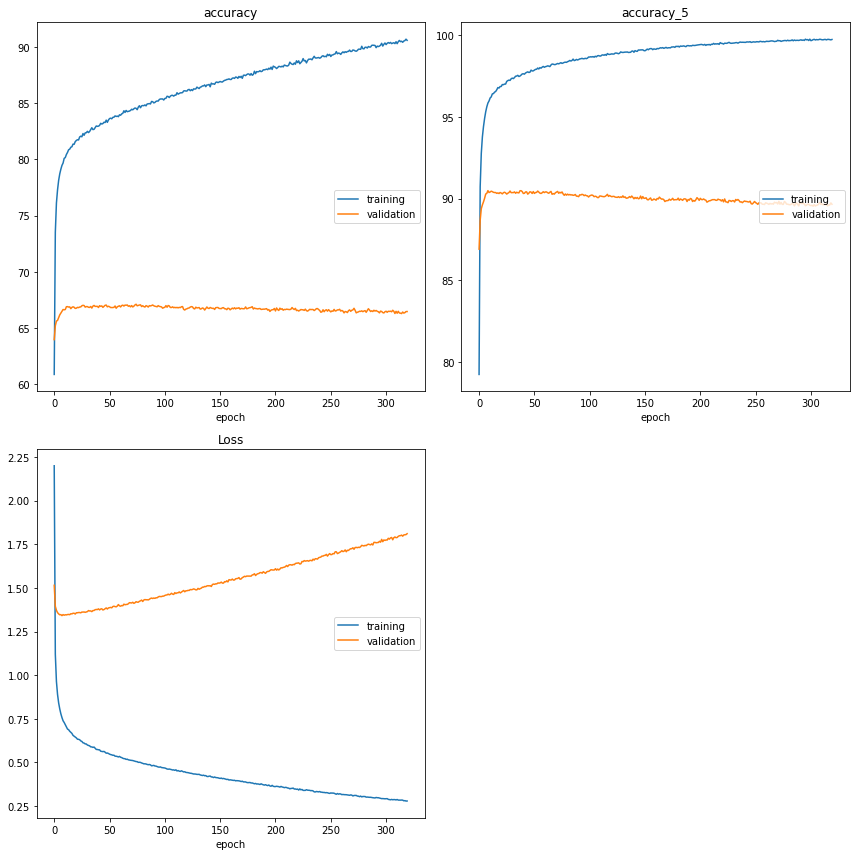

accuracy
	training         	 (min:   60.850, max:   90.713, cur:   90.610)
	validation       	 (min:   63.949, max:   67.102, cur:   66.452)
accuracy_5
	training         	 (min:   79.235, max:   99.758, cur:   99.739)
	validation       	 (min:   86.904, max:   90.485, cur:   89.654)
Loss
	training         	 (min:    0.278, max:    2.200, cur:    0.278)
	validation       	 (min:    1.341, max:    1.811, cur:    1.811)


In [ ]:
liveloss = PlotLosses()
print(f'Training:\n{classifier.model}\nwith batch size: {trainloader.batch_size}')

for epoch in range(1000):
    
    logs = {}
    
    train_result = classifier.train_step()
    
    epoch_loss = sum(train_result[f'{v_models[3].frame_count}_loss']) / len(trainloader)
    epoch_acc1 = sum(train_result[f'{v_models[3].frame_count}_acc1']) / len(trainloader)
    epoch_acc5 = sum(train_result[f'{v_models[3].frame_count}_acc5']) / len(trainloader)
    
    test_result = classifier.test_step()
    
    epoch_loss_ = sum(test_result[f'{v_models[3].frame_count}_loss']) / len(testloader)
    epoch_acc1_ = sum(test_result[f'{v_models[3].frame_count}_acc1']) / len(testloader)
    epoch_acc5_ = sum(test_result[f'{v_models[3].frame_count}_acc5']) / len(testloader)
    
    logs['loss'] = epoch_loss
    logs['accuracy'] = epoch_acc1
    logs['accuracy_5'] = epoch_acc5
    logs['val_loss'] = epoch_loss_
    logs['val_accuracy'] = epoch_acc1_
    logs['val_accuracy_5'] = epoch_acc5_

    liveloss.update(logs)
    liveloss.send()

In [ ]:
class h_mask(object):
    def __init__(self, p: float=0.5):
        self.p = p
        
    def __call__(self, sample):
        x = np.random.choice([0,1], p=[1-self.p, self.p])
        if x:
            

In [29]:
it = iter(trainloader)
x = it.next()

data = it.next()

sampled = classifier._sample_frames(data)

d, l = sampled
out = classifier.model(d)

In [31]:
out.shape

torch.Size([512, 97])

In [ ]:
def _sample_frames(data):
    features = []
    labels = {}
    for feature, label in data:
        video_length = feature.shape[0]
        if video_length < frame_samplers[3].frame_count:
            raise ValueError(f"Video too short to sample {frame_samplers[3].frame_count} from")
        idxs = np.array(frame_idx_to_list(frame_samplers[3].sample(video_length)))
        features.append(feature[idxs])
        for k in label.keys():
            if k in labels:
                labels[k].append(label[k])
            else:
                labels[k] = [label[k]]

    for k in labels.keys():
        try:
            labels[k] = torch.tensor(labels[k])
        except ValueError:
            pass

    return torch.tensor(features, dtype=torch.float), labels

In [ ]:
sampled = _sample_frames(x)

In [21]:
# data, labels = _sample_frames(x)
step = classifier.test_step()

In [27]:
torch.save(classifier.model.state_dict(),'mtrn_verb_frames=4_lr=1e-4_hl=1024_dc=2.pt')

In [24]:
# np.array(list(alie.values())).mean(1)

array([ 2.52381219, 28.89733495, 73.34088978])

In [26]:
classifier.model

V_MTRN(
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (d2): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3_verb): Linear(in_features=512, out_features=97, bias=True)
)

In [40]:
1 % 1000 == 1

True